# Frends

    «Друзья» (англ. Friends) — американский ситком, повествующий о жизни шестерых друзей. Признан одним из лучших комедийных сериалов в истории американского телевидения и стал одним из наиболее знаменитых проектов 1990-х годов[2]. Сама постановка и творческая группа получили множество наград, в том числе шесть премий «Эмми» и премию «Золотой глобус»[3].

Че́ндлер Бинг (Мэттью Перри) — полное имя Че́ндлер Мюриэл Бинг

Чендлер родился в семье писательницы эротических романов Норы Тайлер Бинг и гомосексуала-трансвестита Чарльза Бинга. У Чендлера множество комплексов, от которых он отгораживается постоянными шутками. Работа Чендлера — анализ и реконфигурация данных, и в этой сфере он делает неплохую карьеру. Однако в конце сериала он бросает работу и начинает всё с нуля в рекламном бизнесе. Чендлеру не очень везёт в любви. По существу, у него было всего два более-менее серьёзных романа: с Дженис и с Моникой, на которой он женится в седьмом сезоне сериала.


 Диалоги формаировались на основании https://www.kaggle.com/datasets/amandam1/friends-scripts
 Диалог - это вопрос(контекст - предыдущая реплика)  - ответ персонажа

 Поиск ведется по наиболее релевантному контексту и отдеется реплика персонажа


Нерелевантные примеры  формировались на соновании сценариев к фильмам взятым с   https://imsdb.com/all-scripts.html

In [1]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import os
import re
import json
import pandas as pd


In [2]:
# зафиксируем случайности
seed = 42

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [60]:
# настройки  

# Персонаж для диалога
persona = 'chandler'

output= f"./data/{persona}.json"
other_output='./data/other.json'

# Базовая модель которая будет дообучена 
BASE_MODEL = 'sentence-transformers/all-MiniLM-L6-v2' # выбрана на основании рейтинга MTEB по сотношению качества и компактности

## подготовка данных



In [61]:
# фунция обработки датасета Друзей

def extract_dialogs(filename, character_name=None):
    # Загрузка данных
    df = pd.read_csv(filename)
    
    # Группировка и очистка текста
    grouped = []
    prev_char, current_text = None, []
    
    for _, row in df.iterrows():
        # Очистка от \xa0 и лишних пробелов
        cleaned_line = row['line'].replace('\xa0', ' ').strip()
        if row['character'] == prev_char:
            current_text.append(cleaned_line)
        else:
            if prev_char is not None:
                grouped_text = ' '.join(current_text)
                grouped.append({'character': prev_char, 'text': grouped_text})
            prev_char = row['character']
            current_text = [cleaned_line]
    # Добавляем последнюю группу
    if prev_char is not None:
        grouped_text = ' '.join(current_text)
        grouped.append({'character': prev_char, 'text': grouped_text})
    
    # Формирование пар
    dialogs = []
    for i in range(len(grouped) - 1):
        question = grouped[i]['text']
        answer = grouped[i + 1]
        dialogs.append({
            'character': answer['character'],  # Ответивший
            'q': question,
            'a': answer['text']
        })
    
    # Фильтрация по отвечающему
    if character_name:
        dialogs = [d for d in dialogs if d['character'] == character_name]
    
    return dialogs

In [62]:
# получим все ответы персонажа с контекстом вопросом
person_dialogs = extract_dialogs('./data/friends.csv', persona)

# сохраним диалоги в файл
with open(output, 'w', encoding='utf-8') as file:
    json.dump(person_dialogs, file, ensure_ascii=False, indent=4)

# Первые 3 ответа персонажа
person_dialogs[:3]

[{'character': 'chandler',
  'q': "c'mon, you're going out with the guy! there's gotta be something wrong with him!",
  'a': 'all right joey, be nice.  so does he have a hump? a hump and a hairpiece?'},
 {'character': 'chandler',
  'q': "okay, everybody relax. this is not even a date. it's just two people going out to dinner and- not having sex.",
  'a': "sounds like a date to me. alright, so i'm back in high school, i'm standing in the middle of the cafeteria, and i realize i am totally naked."},
 {'character': 'chandler',
  'q': 'oh, yeah. had that dream.',
  'a': "then i look down, and i realize there's a phone... there."}]

In [63]:
# Функция обработки текстового формата сценариев и извлечения диалогов
def parse_dialogs(file_path, target_character=None):
    with open(file_path, 'r', encoding='utf-8') as f:
        script_text = f.read()    
    dialogs = []
    current_dialog = None
    previous_dialog = None
    actions_between = []
    
    character_pattern = re.compile(r'^([A-Z][A-Z\s\-\']+)(\s+\(.*?\))?\s*$')
    
    for line in script_text.split('\n'):
        line = line.strip()
        
        # Определяем строку с персонажем
        match = character_pattern.match(line)
        if match:
            # Сохраняем предыдущий диалог если он соответствует фильтру
            if current_dialog:
                if target_character is None or current_dialog['character'] == target_character:
                    dialogs.append({'character':current_dialog['character'],'q': ' '.join(current_dialog['context']), 'a' : ' '.join(current_dialog['lines'])})
                previous_dialog = current_dialog
                
            # Создаем новый диалог
            current_character = match.group(1).strip()
            current_dialog = {
                'character': current_character,
                'lines': [],
                'context': []
            }
            
            # Добавляем контекст: предыдущая реплика + действия
            if previous_dialog:
                prev_lines = f"{previous_dialog['character']}: {' '.join(previous_dialog['lines'])}"
                current_dialog['context'].append(prev_lines)
            current_dialog['context'].extend(actions_between)
            actions_between = []
            continue
        
        # Собираем действия между репликами
        if line.startswith('(') and line.endswith(')'):
            action = line[1:-1].strip()
            if current_dialog:
                current_dialog['context'].append(action)
            else:
                actions_between.append(action)
            continue
        
        # Собираем текст реплики
        if current_dialog and line:
            current_dialog['lines'].append(line)
    
    # Добавляем последний диалог если соответствует фильтру
    if current_dialog and (target_character is None or current_dialog['character'] == target_character):
        dialogs.append({'character':current_dialog['character'],'q': ' '.join(current_dialog['context']), 'a' : ' '.join(current_dialog['lines'])})
    
    return dialogs

In [64]:
# функция обработки файлов папки
def process_all_files(persona="THREEPIO", data_dir='data', output_file='all_answers.json'):
    all_dialogues = []
    
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.txt'):
                input_file = os.path.join(root, file)                 
                print(f"Обработка файла: {input_file}")                
                dialogs = parse_dialogs(input_file, persona)
                all_dialogues.extend(dialogs)


    with open(output_file, 'w', encoding='utf-8') as file:
        json.dump(all_dialogues, file, ensure_ascii=False, indent=4)
        print(f"JSON-файл сохранен: {output_file}, записано строк: {len(all_dialogues)}")                
    print(f"Объединенный JSON-файл сохранен как: {output_file}")
    return all_dialogues

In [65]:
# Запуск обработки файлов сценариев из других вселенных для создания "неправильных" ответов
other_dialogs = process_all_files(persona = None, data_dir='data/other', output_file=other_output)

Обработка файла: data/other\KUNG FU PANDA.txt
Обработка файла: data/other\PEARL HARBOR.txt
Обработка файла: data/other\SW_Episode1.txt
Обработка файла: data/other\SW_Episode2.txt
Обработка файла: data/other\SW_Episode3.txt
Обработка файла: data/other\SW_Episode4.txt
Обработка файла: data/other\SW_Episode5.txt
Обработка файла: data/other\SW_Episode6.txt
Обработка файла: data/other\SW_Episode7.txt
Обработка файла: data/other\WILD WILD WEST.txt
JSON-файл сохранен: ./data/other.json, записано строк: 8474
Объединенный JSON-файл сохранен как: ./data/other.json


In [66]:
len(other_dialogs), other_dialogs[77]

(8474,
 {'character': 'SHIFU',
  'q': 'OOGWAY: One often meets his destiny on the road he takes to avoid it.',
  'a': "We have to do something. We can't just let him march on the valley, and take his revenge! He'll, he'll-- Oogway looks into the water of the moon pool."})

In [67]:
# создание данных для обучения Bi-Encoder
import random

def augment_dataset_bi(dialogs_list, other_list, num_negative_samples=1):
    # 1. Добавляем поле label=0 ко всем существующим диалогам
    for dialog in dialogs_list:
        dialog['label'] = 0
    
    # Собираем все возможные ответы для негативных примеров
    all_answers = [d['a'] for d in other_list]
    
    # 2. Генерируем негативные примеры
    negative_samples = []
    for _ in range(num_negative_samples):
        # Выбираем случайный диалог
        original = random.choice(dialogs_list)
        
        # Выбираем случайный ответ, отличный от оригинального
        random_answer = random.choice(all_answers)
        while random_answer == original['a']:  # Гарантируем различие
            random_answer = random.choice(all_answers)
        
        # Создаем негативный пример
        negative_sample = {
            'character': original['character'],
            'q': original['q'],
            'a': random_answer,
            'label': 1
        }
        negative_samples.append(negative_sample)
    
    # Объединяем оригинальные и негативные примеры
    return dialogs_list + negative_samples

In [68]:
# Аугментированный датасет со сбалансированными  негативными примерами
augmented_for_bi = augment_dataset_bi(person_dialogs, other_dialogs, num_negative_samples=len(person_dialogs))

In [69]:
#создание данных для обучения Cross-Encoder
def augment_dataset_cross(dialogs_list, other_list, num_negative_samples=1):
    # 1. Добавляем поле label=1 ко всем существующим диалогам
    for dialog in dialogs_list:
        dialog['label'] = 1
    
    # Собираем все возможные ответы для негативных примеров
    all_answers = [d['a'] for d in other_list]
    
    # 2. Генерируем негативные примеры
    negative_samples = []
    for _ in range(num_negative_samples):
        # Выбираем случайный диалог
        original = random.choice(dialogs_list)
        
        # Выбираем случайный ответ, отличный от оригинального
        random_answer = random.choice(all_answers)
        while random_answer == original['a']:  # Гарантируем различие
            random_answer = random.choice(all_answers)
        
        # Создаем не релевантные примеры
        negative_sample = {
            'character': original['character'],
            'q': original['q'],
            'a': random_answer,
            'label': 0
        }
        negative_samples.append(negative_sample)
    
    # Объединяем оригинальные и негативные примеры
    return dialogs_list + negative_samples

In [70]:
# Аугментированный датасет со сбалансированными  примерами по близости
augmented_for_cross = augment_dataset_cross(person_dialogs, other_dialogs, num_negative_samples=len(person_dialogs))

## Обучение моделей

### Bi-Encoder

In [14]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
%%time

MAX_LENGTH = 128

tokenized_question = tokenizer([dialog["q"] for dialog in augmented_for_bi],
                               max_length=MAX_LENGTH, padding="max_length",
                               truncation=True, verbose=True)

tokenized_answer = tokenizer([dialog["a"] for dialog in augmented_for_bi],
                                 max_length=MAX_LENGTH, padding="max_length",
                                 truncation=True, verbose=True)

CPU times: total: 1.67 s
Wall time: 877 ms


In [16]:
class DialogDataset(Dataset):
    def __init__(self, question_tokens: dict, answer_tokens: dict, labels: Iterable[str]):
        self.question_tokens = question_tokens
        self.answer_tokens = answer_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am, label  in zip(
            self.question_tokens["input_ids"], self.question_tokens["attention_mask"],
            self.answer_tokens["input_ids"], self.answer_tokens["attention_mask"],
            self.labels
        ):
            data = {}
            data["question_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["question_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["answer_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["answer_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            data["label"] = torch.tensor(label, dtype=torch.long)            
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [17]:
dialog_dataset = DialogDataset(tokenized_question, tokenized_answer, (data["label"] for data in augmented_for_bi))

In [18]:
train_ratio = 0.9
n_total = len(dialog_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(dialog_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [21]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained(BASE_MODEL)
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 3)

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        question_input_ids = data["question_input_ids"].to(device)
        question_attention_mask = data["question_attention_mask"].to(device)
        answer_input_ids = data["answer_input_ids"].to(device)
        answer_attention_mask = data["answer_attention_mask"].to(device)

        out_question = self.bert_model(question_input_ids, question_attention_mask)
        out_answer = self.bert_model(answer_input_ids, answer_attention_mask)
        question_embeds = out_question.last_hidden_state
        answer_embeds = out_answer.last_hidden_state

        pooled_question_embeds = mean_pool(question_embeds, question_attention_mask)
        pooled_answer_embeds = mean_pool(answer_embeds, answer_attention_mask)

        embeds =  torch.cat([pooled_question_embeds, pooled_answer_embeds,
                             torch.abs(pooled_question_embeds - pooled_answer_embeds)],
                            dim=-1)
        return self.linear(embeds)

In [22]:
model = Sbert().to(device)

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [24]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 10) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [25]:
%%time

n_epochs = 1  # mentioned in the paper

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


step     0/922, loss =  1.150
step   160/922, loss =  0.667
step   320/922, loss =  0.113
step   480/922, loss =  0.046
step   640/922, loss =  0.030
step   800/922, loss =  0.029

Validating ...
step     0/103, loss =  0.020
CPU times: total: 11.2 s
Wall time: 32.4 s


In [26]:
model.bert_model.save_pretrained("models/biencoder")

In [27]:
window_size = 1

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

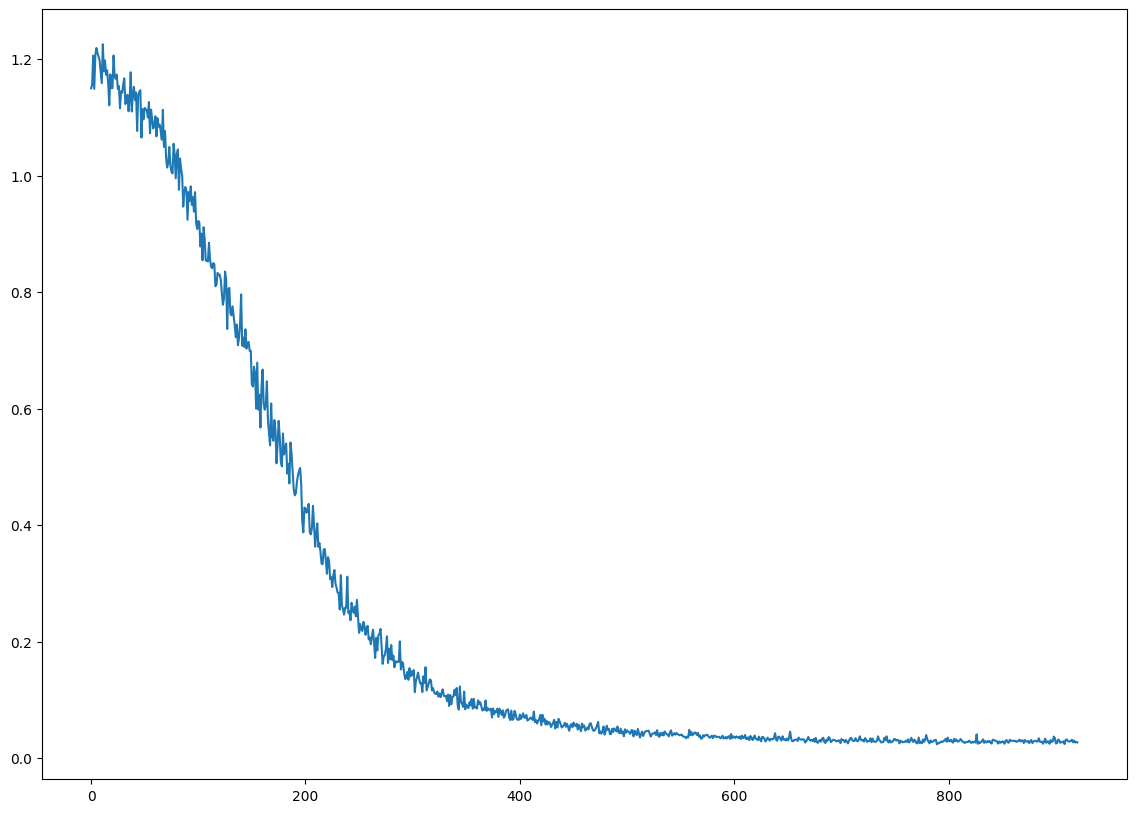

In [28]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

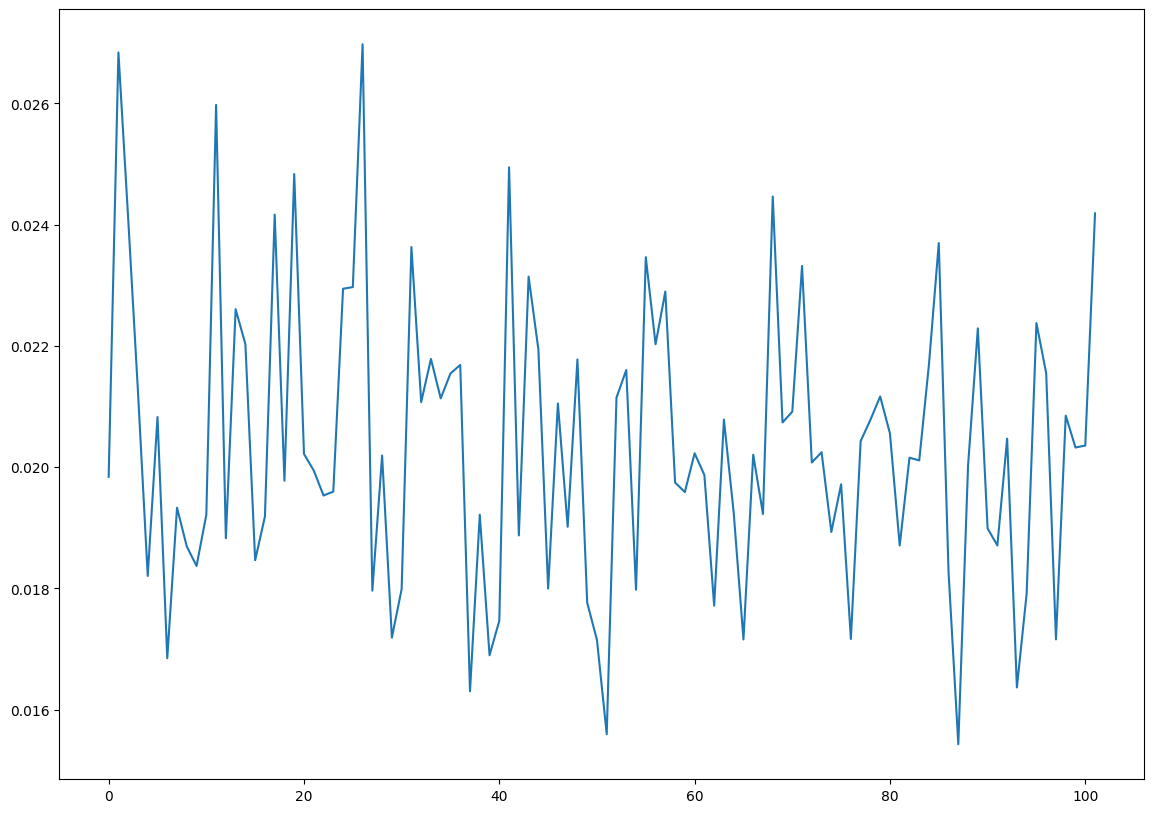

In [29]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(val_mb_running_loss)), val_mb_running_loss);

Вывод: Из графика видно модель хорошо обучилась, на валидационной выборке сразу низкий лосс

### Cross-Encoder

In [30]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
bert_model = AutoModel.from_pretrained(BASE_MODEL)

c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
%%time

MAX_LENGTH = 128

tokenized_texts = tokenizer([data["q"] for data in augmented_for_cross],
                            [data["a"] for data in augmented_for_cross],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

CPU times: total: 1.97 s
Wall time: 861 ms


In [32]:
class RankDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])


In [33]:
%%time

rank_dataset = RankDataset(tokenized_texts, [data["label"] for data in augmented_for_cross])

CPU times: total: 15.6 ms
Wall time: 1.01 ms


In [34]:
train_ratio = 0.8
n_total = len(rank_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(rank_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [35]:
len(train_dataloader), len(val_dataloader)

(819, 205)

In [36]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained(BASE_MODEL)
        self.bert_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrossEncoderBert().to(device)

In [38]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [39]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()

def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

In [40]:
%%time

n_epochs = 2

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/819, Loss = 0.607
Step    64/819, Loss = 0.151
Step   128/819, Loss = 0.143
Step   192/819, Loss = 0.137
Step   256/819, Loss = 0.084
Step   320/819, Loss = 0.090
Step   384/819, Loss = 0.055
Step   448/819, Loss = 0.078
Step   512/819, Loss = 0.178
Step   576/819, Loss = 0.109
Step   640/819, Loss = 0.181
Step   704/819, Loss = 0.086
Step   768/819, Loss = 0.151
Step     0/205, Loss = 0.060
Step    64/205, Loss = 0.034
Step   128/205, Loss = 0.079
Step   192/205, Loss = 0.051

Epoch 2
Step     0/819, Loss = 0.057
Step    64/819, Loss = 0.095
Step   128/819, Loss = 0.165
Step   192/819, Loss = 0.068
Step   256/819, Loss = 0.121
Step   320/819, Loss = 0.035
Step   384/819, Loss = 0.137
Step   448/819, Loss = 0.022
Step   512/819, Loss = 0.034
Step   576/819, Loss = 0.013
Step   640/819, Loss = 0.062
Step   704/819, Loss = 0.072
Step   768/819, Loss = 0.061
Step     0/205, Loss = 0.060
Step    64/205, Loss = 0.034
Step   128/205, Loss = 0.079
Step   192/205, Loss = 0.

In [41]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

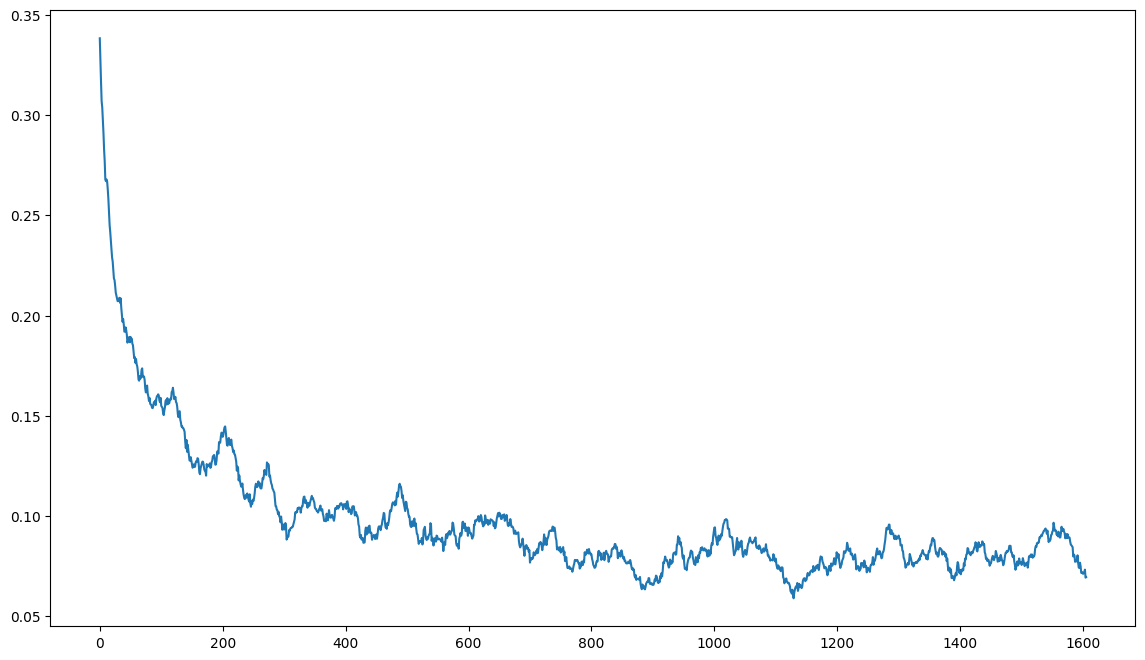

In [42]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

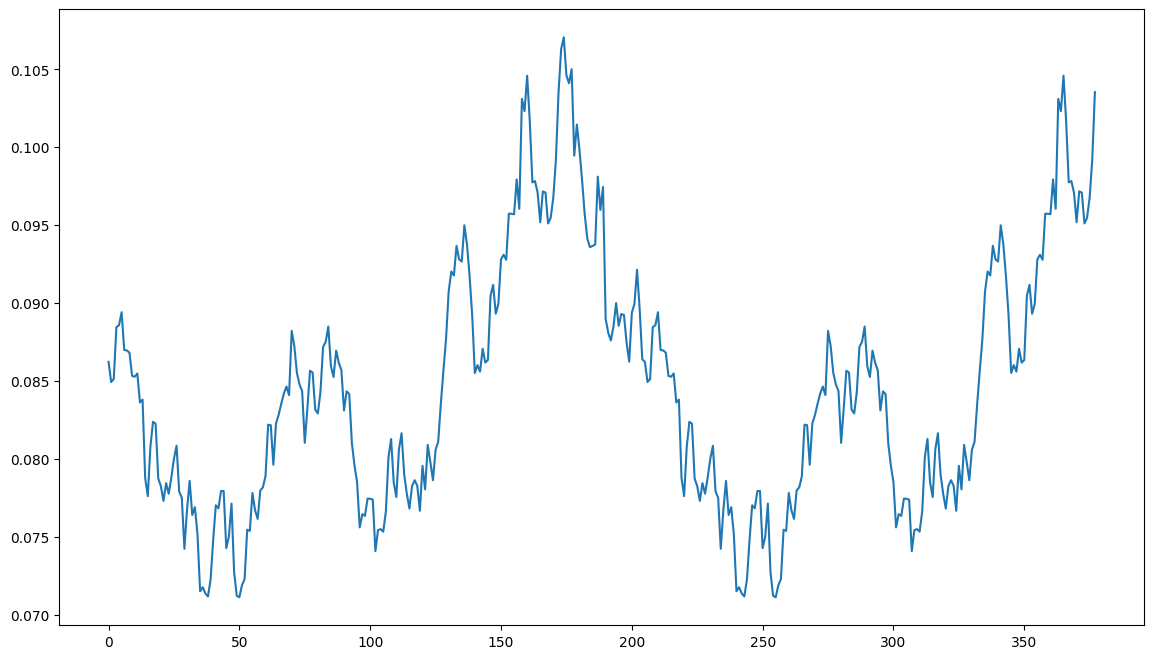

In [43]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(val_mb_running_loss)), val_mb_running_loss);

In [44]:
torch.save(model,"models/crossencoder.pt")

In [45]:
tokenizer.save_pretrained('models/fiendstokenizer')

('models/fiendstokenizer\\tokenizer_config.json',
 'models/fiendstokenizer\\special_tokens_map.json',
 'models/fiendstokenizer\\vocab.txt',
 'models/fiendstokenizer\\added_tokens.json',
 'models/fiendstokenizer\\tokenizer.json')

Вывод: Из графика видно модель хорошо обучилась, на валидационной выборке сразу низкий лосс

## Инференс

In [ ]:
import os
import re
import json
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# упрощенная локальная векторная БД
class DialogueRetrieval:
    def __init__(self, model, tokenizer, data_file='dialogues.json'):
        self.tokenizer = tokenizer #BertTokenizer.from_pretrained(model_name)
        self.model = model #BertModel.from_pretrained(model_name)
        self.data_file = data_file
        self.dialogues = self.load_dialogues()
        self.embeddings = self.get_bert_embeddings([d["q"] for d in self.dialogues]) if self.dialogues else np.array([])
    
    def load_dialogues(self):
        if os.path.exists(self.data_file):
            with open(self.data_file, 'r', encoding='utf-8') as file:
                return json.load(file)
        return []
    
    def save_dialogues(self):
        with open(self.data_file, 'w', encoding='utf-8') as file:
            json.dump(self.dialogues, file, ensure_ascii=False, indent=4)
    
    def get_bert_embeddings(self, texts):
        embeddings = []
        for text in texts:
            inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = self.model(**inputs)
                cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
        return np.array(embeddings)
    
    def add_dialogue(self, question, answer):
        self.dialogues.append({"question": question, "answer": answer})
        self.save_dialogues()
        self.embeddings = self.get_bert_embeddings([d["question"] for d in self.dialogues])
    
    def remove_dialogue(self, question):
        self.dialogues = [d for d in self.dialogues if d["question"] != question]
        self.save_dialogues()
        self.embeddings = self.get_bert_embeddings([d["question"] for d in self.dialogues]) if self.dialogues else np.array([])
    
    def search_answer(self, query, top_n=1):
        if not self.dialogues:
            return ["Ответ не найден."]
        query_embedding = self.get_bert_embeddings([query])
        cos_similarities = cosine_similarity(query_embedding, self.embeddings).flatten()
        top_indices = np.argsort(cos_similarities)[-top_n:][::-1]
        return [self.dialogues[i]["a"] for i in top_indices]

    def load_from_json(self, file_path):
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                self.dialogues = json.load(file)
                self.embeddings = self.get_bert_embeddings([d["question"] for d in self.dialogues]) if self.dialogues else np.array([])
                self.save_dialogues()
                print(f"Данные загружены из {file_path}")
        else:
            print("Файл не найден.")





### простые запросы

In [ ]:
# загрузим сохраненные точки
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('models/fiendstokenizer')
model_bi_enc = AutoModel.from_pretrained('models/biencoder')
model_cross_enc = torch.load("models/crossencoder.pt")




In [ ]:
# создадим свою векторную БД
retrieval = DialogueRetrieval(model=model_bi_enc, tokenizer= tokenizer, data_file= output)


In [ ]:
#проверим работу
retrieval.search_answer("How are you?", top_n=5)


["well, our names really are monica and chandler. we're from new york.",
 'we’re you just ten seconds later!',
 '(surprised) it is?',
 "hey. well, you will all be pleased to know that i have a date tomorrow night. this woman, alison, from work. she's great. she's pretty, she's smart. and uh, i've been holding off on asking her out in the past, because she has an unusually large head. but, i'm not gonna let that stuff hang me up anymore. look at me. i'm growing.",
 'so.... i quit.']

In [50]:
query = "and they weren't looking at you before?!"
corpus = retrieval.search_answer(query, top_n=10)

In [51]:
corpus

["finally, i figure i'd better answer it, and it turns out it's my mother, which is very-very weird, because- she never calls me!",
 'thank you! (they hug.) all right, i gotta go unpack.',
 'oh my god!',
 "yeah, i wouldn't know having missed everything.",
 'well what is wrong with me? am i .. am i incomptent? because i managed to survive whatever it is that killed the three of you!',
 'eh! joey! joey! joey! j-j-joey-joey-j-joey! (monica hides under the covers as joey enters. remember?)',
 "'look, gippetto, i'm a real live boy.'",
 'and people say you don’t pay attention. no, this is a much better job. it’s vice-president of a company that does data reconfiguration and statistical factoring for other companies.',
 'listen, this is totally getting out of hand! okay? she wants me to put lotion on her!',
 'what?']

In [ ]:
#сравнение с базовой моделью
def get_ranked_docs(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel, query: str, corpus: list[str]
) -> None:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Base Bert model scoring
    with torch.no_grad():
        base_bert_outputs = base_bert(**tokenized_texts)
        bert_scores = torch.sigmoid(finetuned_ce.linear(base_bert_outputs.last_hidden_state[:, 0, :]))  # Use CLS token output

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

    # Process scores for base Bert model
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.cpu().numpy().squeeze(-1)
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [54]:

get_ranked_docs(tokenizer, model_cross_enc, bert_model.to(device), query, corpus)

Query - and they weren't looking at you before?! [Finetuned Cross-Encoder]
---
0.74	listen, this is totally getting out of hand! okay? she wants me to put lotion on her!
0.73	eh! joey! joey! joey! j-j-joey-joey-j-joey! (monica hides under the covers as joey enters. remember?)
0.72	finally, i figure i'd better answer it, and it turns out it's my mother, which is very-very weird, because- she never calls me!
0.71	thank you! (they hug.) all right, i gotta go unpack.
0.70	'look, gippetto, i'm a real live boy.'
0.69	yeah, i wouldn't know having missed everything.
0.69	oh my god!
0.67	and people say you don’t pay attention. no, this is a much better job. it’s vice-president of a company that does data reconfiguration and statistical factoring for other companies.
0.62	what?
0.57	well what is wrong with me? am i .. am i incomptent? because i managed to survive whatever it is that killed the three of you!

Query - and they weren't looking at you before?! [Bert Base]
---
0.56	well what is wrong

In [ ]:
# получение самого вероятного ответа
def get_ranked(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    query: str, corpus: list[str]
) -> str:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    
    return corpus[scores_ix[0]]


In [55]:
get_ranked(tokenizer, model_cross_enc, query, corpus)

'listen, this is totally getting out of hand! okay? she wants me to put lotion on her!'

In [56]:
query = " i just feel like someone reached down my throat, grabbed my small intestine, pulled it out of my mo..."
corpus = retrieval.search_answer(query, top_n=10)
get_ranked(tokenizer, model_cross_enc, query, corpus)

"'cause, i wanted to uh, give you this. (hands her a present)"

In [57]:
corpus

['cookie?',
 'oh god.',
 'what’s wrong with you?',
 "argh! i can't believe what you did. monica's gonna kill you! (to monica) look! look! look what the... look what... look what the floating heads did!",
 "(reading) knock-knock. who's there? ross geller's lunch. ross geller's lunch, who? ross geller's lunch, please don't take me. okay?",
 "'cause, i wanted to uh, give you this. (hands her a present)",
 'me too.',
 '...dinah?',
 'okay, but you gotta push past this because it is about to get so good!',
 'another hard 8.']

### Gradio

In [ ]:

import gradio as gr

def generate_response(message, history):   
    print(f"\n\n[message] {message}")
    corpus = retrieval.search_answer(message, top_n=10)
    answer = get_ranked(tokenizer, model_cross_enc, message, corpus)
    print(f"\n\n[answer] {answer}")
    return answer


demo = gr.ChatInterface(
    fn=generate_response,
    title=f"Диалог с {persona} из Друзей",
).queue(default_concurrency_limit=2, max_size=10)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://388bf34d5bd06b6e77.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [59]:
# получим все ответы всех персонажей с контекстом вопросом для инференса на qdrant
dialogs = extract_dialogs('./data/friends.csv')

# сохраним диалоги в файл
with open("./data/dialogs.json", 'w', encoding='utf-8') as file:
    json.dump(dialogs, file, ensure_ascii=False, indent=4)

# Первые 3 ответа 
dialogs[:3]

[{'character': 'joey',
  'q': "there's nothing to tell! he's just some guy i work with!",
  'a': "c'mon, you're going out with the guy! there's gotta be something wrong with him!"},
 {'character': 'chandler',
  'q': "c'mon, you're going out with the guy! there's gotta be something wrong with him!",
  'a': 'all right joey, be nice.  so does he have a hump? a hump and a hairpiece?'},
 {'character': 'phoebe',
  'q': 'all right joey, be nice.  so does he have a hump? a hump and a hairpiece?',
  'a': "wait, does he eat chalk? just, 'cause, i don't want her to go through what i went through with carl- oh!"}]